<a href="https://colab.research.google.com/github/Followb1ind1y/Machine_Learning_Algorithms_from_Scratch/blob/main/ML_Algorithms_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Algorithms: Boosting**

## **Boosting Basics**

**Boosting** is an ensemble modeling technique which attempts to build a strong classifier from the number of **weak classifiers**. It is done by building a model using weak models in series. First, a model is built from the training data. Then the second model is built which tries to correct the errors present in the first model. This procedure is continued and models are added until either the complete training data set is predicted correctly or the maximum number of models are added.

Boosting being a sequential process, **each subsequent model attempts to correct the errors of the previous model**. It is focused on reducing the bias unlike bagging. It makes the boosting algorithms **prone to overfitting**. To avoid overfitting, parameter tuning plays an important role in boosting algorithms.

A **Weak Classifier** is one whose error rate is only **slightly better than random guessing**. Theoretically a weak classifier can be boosted to perform pretty well. To find weak learners, we apply base learning (ML) algorithms with a different distribution. As each time base learning algorithm is applied, it generates a new weak prediction rule. This is an iterative process. After many iterations, the boosting algorithm combines these weak rules into a single strong prediction rule.


## **Boosting Algorithm**

1. Initialize all weights to $w_{i}=\frac{1}{n}$ where $n$ is the number of instances in the dataset.

2. For $i=1$ to $m$,
    * a) Create a model and get the hypothesis $h_{j}(x) = \arg \min L_{j}$ that minimize $L_{j}=\frac{\sum_{i=1}^{n}w_{i}I(y_{i}\neq h(x_{i}))}{\sum_{i=1}^{n}w_{i}}$
    * b) Compute $\alpha_{j}=log(\frac{1-L_{j}}{L_{j}})$
    * c) Set $w_{i} := w_{i}e^{\alpha_{j}I(y_{i}\neq h(x_{i}))}$

*  If classified correctly, the weight of an observation remains unchanged.
*  If classified incorrectly, the weight is increased by multiplying
$e^{\alpha_{j}}$
* Alpha varies with the degree of misclassification

3. Final classification

$$
h(x_{i}) =sign[\sum_{j=1}^{m}\alpha_{j}h_{j}(x)]
$$

## **Dataset Initialization**

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [203]:
np.random.seed(0)

x_1, x_2 = (np.random.rand(50, 1)-0.5)*2, np.random.rand(50, 1)*0.75 - 0.5
y_1, y_2 = -(x_1)**2 + np.random.rand(50, 1) + 2, np.random.rand(50, 1) + 1

class_1, class_2 = np.concatenate((x_1, y_1), axis=1), np.concatenate((x_2, y_2), axis=1)
zeros, ones = -np.ones((50,1)), np.ones((50,1))
x = np.concatenate((class_1, class_2), axis=0)
y = np.concatenate((zeros, ones), axis=0)

Text(0, 0.5, 'X2')

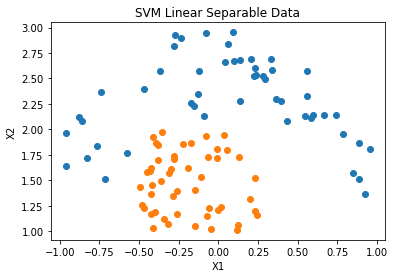

In [204]:
fig, ax = plt.subplots() 
ax.scatter(x_1,y_1) 
ax.scatter(x_2,y_2) 
ax.set_title('SVM Linear Separable Data')
ax.set_xlabel('X1') 
ax.set_ylabel('X2')

In [205]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

## **Implementing AdaBoost from scratch**

In [206]:
from sklearn.tree import DecisionTreeClassifier

In [207]:
class Adaboost:
    def __init__(self, m=100, learning_rate=1):
        self.m = m
        self.learning_rate = learning_rate

    def compute_error(self, y, y_pred, w_i):
        return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)
    
    def compute_alpha(self, error):
        return self.learning_rate * np.log((1 - error) / error)

    def update_w_i(self, y, y_pred, alpha, w_i):
        return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))
    
    def fit(self, x, y):
        n = x.shape[0]
        self.models_list, self.alpha_list, self.sample_weight_list = [],[],[]

        sample_weight = np.ones(n) / n
        self.sample_weight_list.append(sample_weight)

        for i in range(self.m):
            sample_weight = self.sample_weight_list[-1]
            model = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
            model.fit(x, y, sample_weight=sample_weight)
            y_pred = model.predict(x)

            error = self.compute_error(y, y_pred, sample_weight)
            alpha = self.compute_alpha(error)
            sample_weight = self.update_w_i(y, y_pred, alpha, sample_weight)

            self.models_list.append(model)
            self.alpha_list.append(alpha)
            self.sample_weight_list.append(sample_weight)
    
    def predict(self, x):
        y_pred_list = []
        for i in range(self.m):   
            y_pred_list.append(self.models_list[i].predict(x)*self.alpha_list[i])
        y_pred = np.sum(y_pred_list, axis=0)
        y_pred = np.sign(y_pred)
        return y_pred

In [208]:
Adaboost = Adaboost(m=10,learning_rate=1)
Adaboost.fit(x_train, y_train.ravel())
Adaboost_y_pred = Adaboost.predict(x_test)

In [209]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape) + 0.5

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

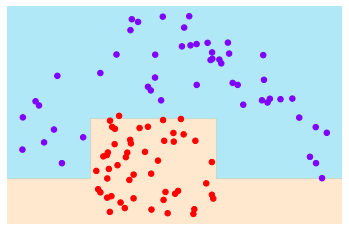

In [210]:
visualize_classifier(Adaboost, x, y.ravel())

## **Implementing AdaBoost from sklearn**

In [211]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [212]:
DT_clf = DecisionTreeClassifier()
DT_model = DT_clf.fit(x_train, y_train)
DT_y_pred = DT_model.predict(x_test)

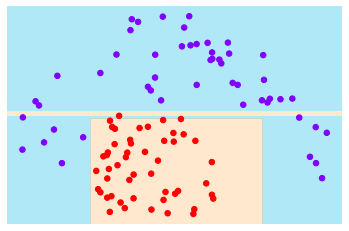

In [213]:
visualize_classifier(DT_clf, x, y)

In [214]:
Ada = AdaBoostClassifier(n_estimators=50,learning_rate=1)
Ada_model = Ada.fit(x_train, y_train.ravel())
Ada_y_pred = Ada_model.predict(x_test)

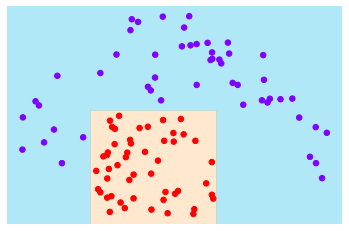

In [215]:
visualize_classifier(Ada, x, y.ravel())

## **Reference**

* Sarkar, P. (2023, January 4). What is boosting and AdaBoost in machine learning? What is Boosting and AdaBoost in Machine Learning? Retrieved January 23, 2023, from `https://www.knowledgehut.com/blog/data-science/boosting-and-adaboost-in-machine-learning` 

* Cano, A. C. (2021, August 9). AdaBoost from scratch. Medium. Retrieved January 23, 2023, from `https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50` 

* Navlani, A. (2018, November 20). AdaBoost classifier algorithms using python Sklearn tutorial. DataCamp. Retrieved January 23, 2023, from `https://www.datacamp.com/tutorial/adaboost-classifier-python` 

In [216]:
%%shell
jupyter nbconvert --to html ML_Algorithms_Boosting.ipynb

[NbConvertApp] Converting notebook ML_Algorithms_Boosting.ipynb to html
[NbConvertApp] Writing 392468 bytes to ML_Algorithms_Boosting.html
